In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
import missingno as msno

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [3]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

## 1. Fearure Engineering
- 1) dataset에 존재하는 null data 채우기
- 2) 아무숫자 x, null data를 포함하는 feature의 statistics 참고 혹은 다른 아이디어
- 3) null data를 어떻게 처리하냐에 따라 모델의 성능이 좌우 됨
- 4) 실제 모델의 학습에 쓰려고 하는 것이기 때문에 train뿐만아니라 test도 똑같이 적용

### 1.1 Fill Null
#### 1.1.1 Fill Null in Age using title
- Age에는 null data가 177개 있다. 여기서 title + statistics 사용
- 영어에서는 Miss, Mrr, Mrs 같은 name title이 존재한다. 이를 사용
- pandas series에는 data를 string으로 바꿔주는 str method를 제공, 또한 정규표현식을 적용해주는 extract method가 있다. 이를 사용하면 title을 쉽게 추출 가능

In [4]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [5]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table을 참고하여 남자, 여자가 쓰는 initial을 구분, replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환

In [6]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)


In [7]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계있는 Miss, Mrs 가 생존률이 높다

<AxesSubplot:xlabel='Initial'>

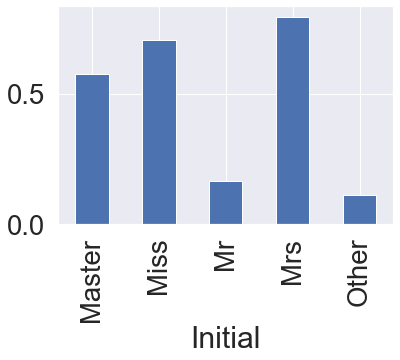

In [8]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- statistics는 train data의 것을 의미, test를 unseen으로 둔 상태로 놔두어야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워 주어야 한다.

In [9]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null value를 채운다
- pandas dataframe을 다룰떄 boolean array를 이용해 indexing하는 방법이 편리하다

In [10]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'), 'Age'] = 46

### 1.1.2 Fill Null in Embarked

In [11]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


- Embarked는 Null value가 2개이고 S에서 가장 많은 탑승객이 있었으므로 S로 채워준다

In [12]:
df_train['Embarked'].fillna('S', inplace=True)

<AxesSubplot:>

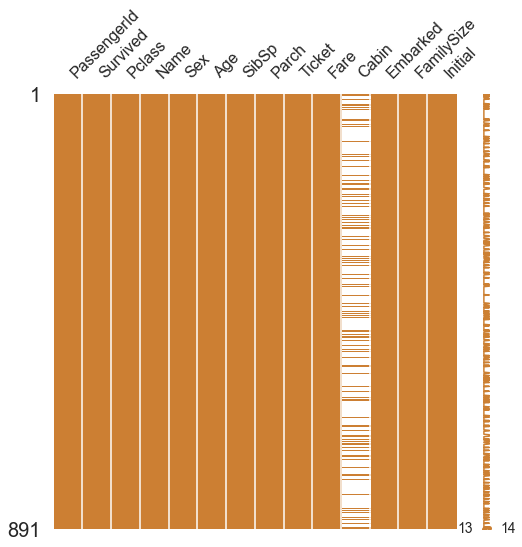

In [13]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color = (0.8, 0.5, 0.2))

## 1.2 Change Age(continuous to categorical)
- Age는 continuous feature이다. 이대로 써도 가능하지만 몇개의 group으로 나누어 category화 시켜줄 수 있다. continuous를 categorical로 바꾸면 information loss가 생길 수 있으니 주의 해야한다.



In [14]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [15]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [16]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change lnitial, Embarked and Sex (String to numerical)
- Initail은 Mr, Mrs, Miss, Master, Other로 총 5개로 이루어져 있다
- 데이터를 모델에 input으로 넣어줄 때 먼저 컴퓨터가 인식 할 수 있도록 수치화 시켜야 한다

In [17]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

In [18]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [19]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [20]:
df_train['Embarked'].isnull().any()

False

In [21]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

### Feature 간의 상관관계
#### 피어슨 상관계수(Pearson Correlation Coeffcient)
- 두 변수간 피어슨 상관계수를 구하면 (-1, 1)사이의 값을 얻을 수 있다.
- -1로 갈 수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미
- 0에 근접 할 수록 상관관계가 없다라는 의미

## $ r_{xy} = \frac{공분산}{표준편차 * 표준편차} = {{1 \over n-1} \sum_{k=1}^N  (x_{i} - \bar{x})(y_{i} - \bar{y}) \over S_{x}S_{y} }$

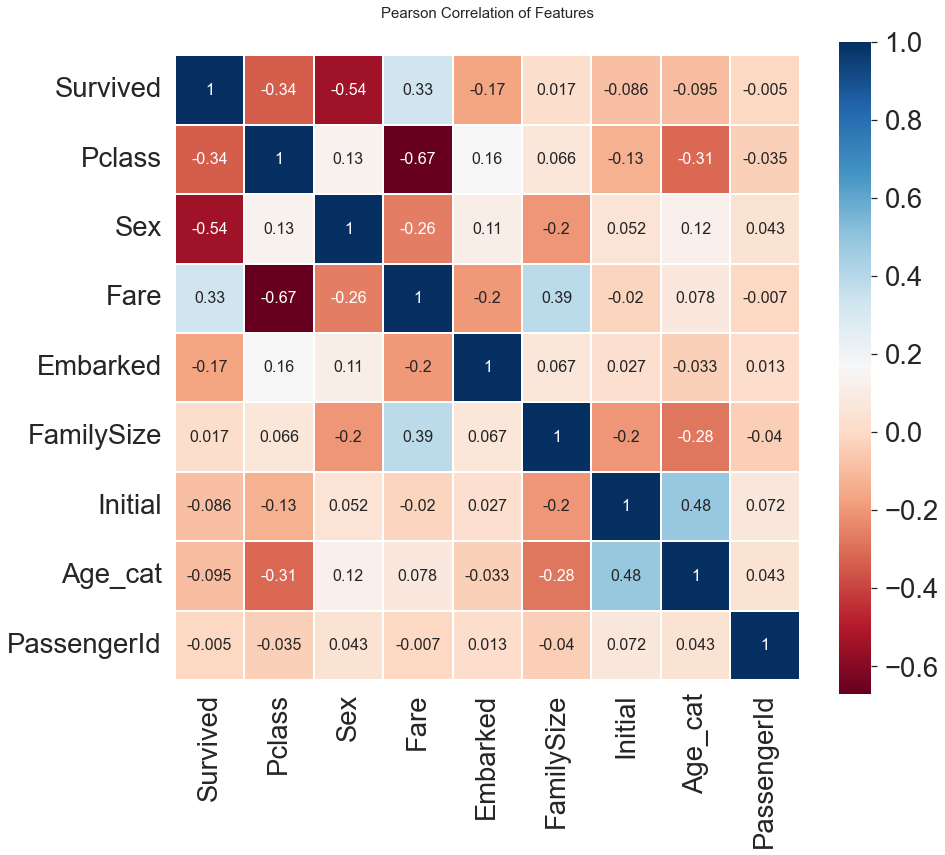

In [22]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked',
                        'FamilySize', 'Initial', 'Age_cat', 'PassengerId']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})
del heatmap_data

- Sex와 Pclass가 Survived에 상관관계가 어느정도 있다.
- Fare와 Embarked도 상관관계가 있다.
- 특별하게 강한 상관관계가 있는 feature가 없다면 이것은 불필요한 feature가 없다는 의미이다.

## 4. One-hot encoding on lnitial and Embarked
- 수치화 시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있다.
- one-hot encoding은 (0, 1)로 이루어진 벡터로 나타내는 것

In [23]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [24]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [25]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [26]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,3,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,1,3,0,0,1,0,0,0,0,1


In [27]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [28]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [29]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


## 5. Learning

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix 

In [31]:
train,test=train_test_split(df_train,test_size=0.3,random_state=0,stratify=df_train['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=df_train[df_train.columns[1:]]
Y=df_train['Survived']

### rbf-SVM

In [32]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


### linear-SVM

In [33]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8283582089552238


### Logistic Regression

In [34]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8395522388059702


### Decision Tree

In [35]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.7761194029850746


### K-Nearest Neighbours(KNN)

In [36]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.8059701492537313


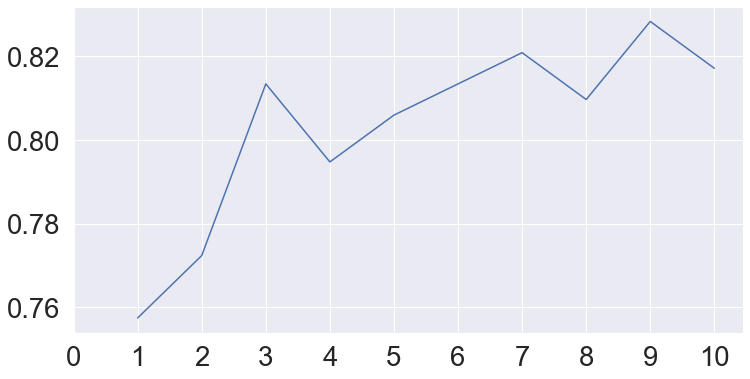

Accuracies for different values of n are: [0.75746269 0.77238806 0.81343284 0.79477612 0.80597015 0.81343284
 0.82089552 0.80970149 0.82835821 0.81716418] with the max value as  0.8283582089552238


In [37]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

### Gaussian Naive Bayes

In [38]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.39925373134328357


### Random Forests

In [39]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8171641791044776


## 6. Cross Validation
1) 모든 데이터 셋을 평가에 활용하기 때문에 데이터셋이 부족할 때 적용하는 방법<br>
2) K개의 성능 결과를 통합하여 하나의 결과를 도출하기 때문에 보다 일반화된 모델 성능 평가 가능 

In [40]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict

In [41]:
kfold = KFold(n_splits=10)
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.828302,0.037179
Radial Svm,0.831648,0.035179
Logistic Regression,0.829426,0.034623
KNN,0.823820,0.033935
Decision Tree,0.783483,0.044030
Naive Bayes,0.759825,0.124520
Random Forest,0.808165,0.047309


<AxesSubplot:>

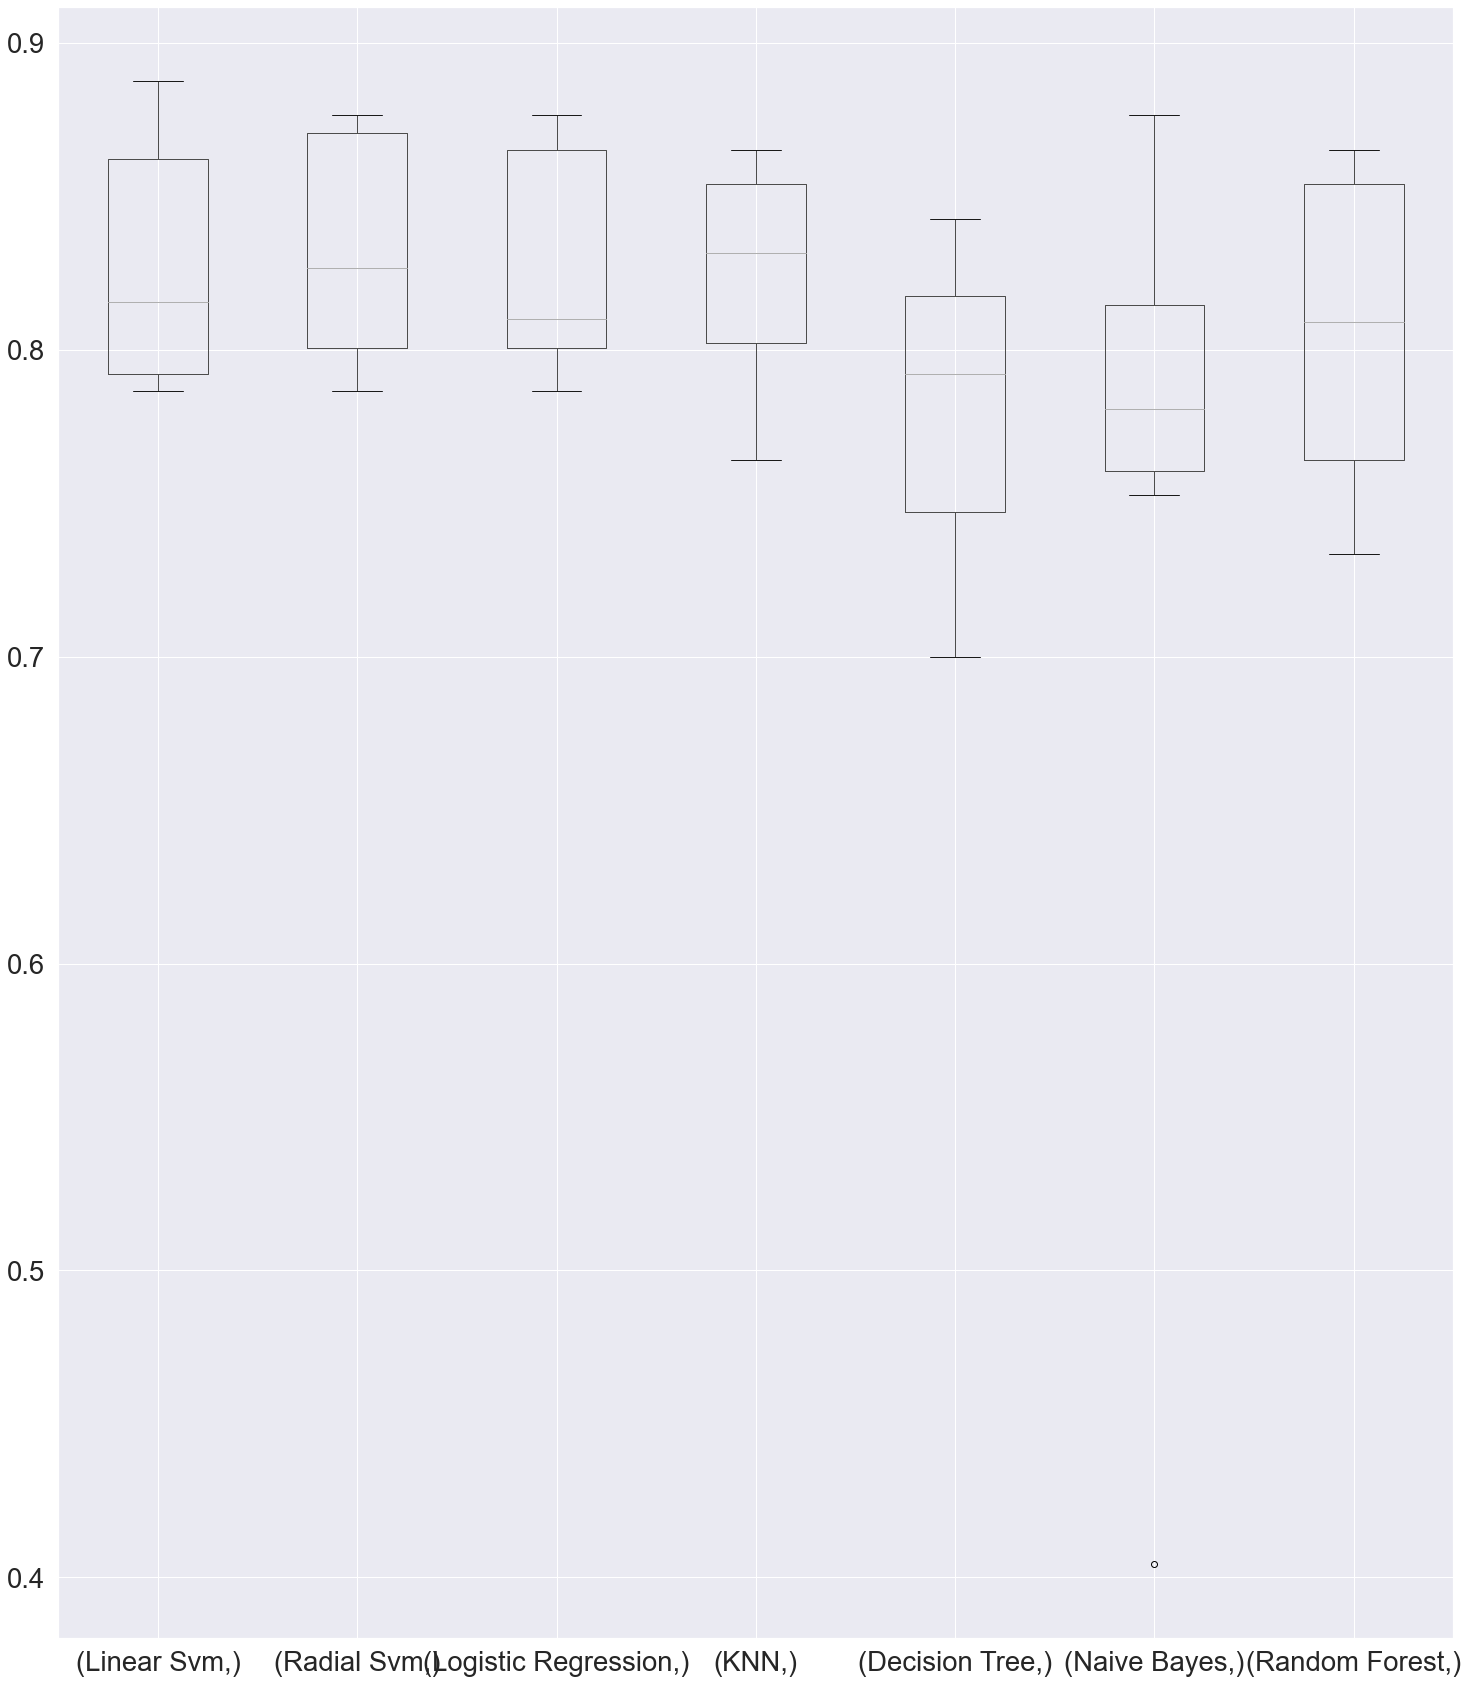

In [42]:
plt.subplots(figsize=(25 ,30))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

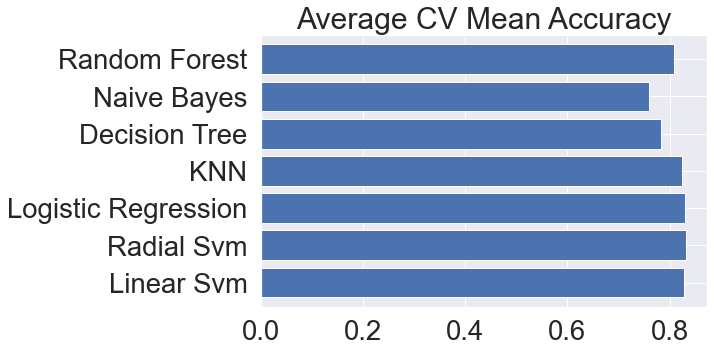

In [43]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

### 7.Model generation and prediction

In [44]:
model = svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X, train_Y)
prediction = model.predict(test_X)

In [45]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(test_Y.shape[0], 100 * metrics.accuracy_score(prediction, test_Y)))

총 268명 중 83.58% 정확도로 생존을 맞춤


In [46]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)
prediction = model.predict(test_X)

In [47]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(test_Y.shape[0], 100 * metrics.accuracy_score(prediction, test_Y)))

총 268명 중 78.36% 정확도로 생존을 맞춤
